# mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare libraries

In [ ]:
%%capture
! pip install ttach

In [ ]:
%cd drive/MyDrive/pytorch-grad-cam/

/content/drive/.shortcut-targets-by-id/1-25SjPsUAwOBfBGNtQeQuroNzEHhfY07/pytorch-grad-cam


In [ ]:
import os
import random
import pandas as pd
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pytorch_grad_cam.xgrad_cam import XGradCAM
# from torchinfo import summary
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler


In [ ]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

In [ ]:
# Hyperparameters

with_softmax = False
is_cam = False
dropout = False

arg_softmax = 'softmax' if with_softmax else 'normal'
arg_cam = 'cam' if is_cam else 'grad'
arg_dropout = 'with_dropout' if dropout else 'without_dropout'

## Load Dataset for Training

In [ ]:
def create_dataset(is_train = False):
  if is_train:
    n_maj = 10000
    n_min = 500
  else:
    n_maj = n_min = 1000

  # mean_vals = np.array([0.9, 0.7, 0.5, 0.3, 0.1, -0.2, -0.4])
  # std_vals = np.array([0.6, 2.5, 0.2, 1.2, 0.02, 0.04, 1.7])

  mean_vals = np.array([1] * 7)
  std_vals = np.array([0.6, 2.5, 0.2, 1.2, 0.02, 0.04, 1.7])


  n_feats = len(mean_vals)


  maj_0 = np.concatenate([
                      np.random.normal(mean_vals, std_vals, size=(n_maj, n_feats)),
                      np.random.normal(mean_vals, std_vals, size=(n_maj, n_feats)),
                      ], axis=-1)

  min_0 = np.concatenate([
                      np.random.normal(mean_vals, std_vals, size=(n_min, n_feats)),
                      np.random.normal(-mean_vals, std_vals, size=(n_min, n_feats)),
                      ], axis=-1)

  maj_1 = np.concatenate([
                      np.random.normal(-mean_vals, std_vals, size=(n_maj, n_feats)),
                      np.random.normal(-mean_vals, std_vals, size=(n_maj, n_feats)),
                      ], axis=-1)

  min_1 = np.concatenate([
                      np.random.normal(-mean_vals, std_vals, size=(n_min, n_feats)),
                      np.random.normal(mean_vals, std_vals, size=(n_min, n_feats)),
                      ], axis=-1)

  features =torch.Tensor(np.concatenate([
      maj_0,
      min_0,
      maj_1,
      min_1
  ], axis = 0))

  labels = torch.Tensor(np.concatenate([
      np.zeros((n_maj)),
      np.zeros((n_min)),
      np.ones((n_maj)),
      np.ones((n_min))
  ], axis = 0))

  sp_labels = torch.Tensor(np.concatenate([
      np.zeros((n_maj)),
      np.ones((n_min)),
      np.ones((n_maj)),
      np.zeros((n_min))
  ], axis = 0))


  groups = labels + 2 * sp_labels

  perm = torch.randperm(len(features))

  features = features[perm, :]
  labels = labels[perm]
  groups = groups[perm]

  return features, labels, groups



In [ ]:
train_features, train_labels, train_groups = create_dataset(is_train = True)
test_features, test_labels, test_groups = create_dataset(is_train = False)

train_dataset = TensorDataset(train_features, train_labels, train_groups)
test_dataset = TensorDataset(test_features, test_labels, test_groups)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

# Train Linear classifier

In [ ]:
if dropout:
  model = nn.Sequential(
      nn.Dropout(),
      nn.Linear(14, 2)
  )
else:
  model = nn.Sequential(
      nn.Linear(14, 2)
  )

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [ ]:
def train(model, dataloader, optimizer, criterion, epoch):
  model.train()

  with tqdm(iterable = enumerate(dataloader), total = len(dataloader)) as pbar:
    for i, (feature, label, _) in pbar:
      feature = feature.to(device)
      label = label.to(device).long()

      optimizer.zero_grad()

      out = model(feature)
      loss = criterion(out, label)
      loss.backward()
      optimizer.step()

def test(model, dataloader, criterion):
  model.eval()
  avg_acc = 0
  env_acc = [0] * 4
  env_total = [0] * 4

  with tqdm(iterable = enumerate(dataloader), total = len(dataloader)) as pbar:
    for i, (feature, label, groups) in pbar:
      feature = feature.to(device)
      label = label.to(device).long()
      groups = groups.to(device)

      out = model(feature)
      avg_acc += torch.sum(torch.argmax(out, dim = 1) == label).item()
      for g in range(4):
        indices = torch.argwhere(groups == g).squeeze()
        if len(indices.shape) == 0:
          continue

        env_acc[g] += torch.sum(torch.argmax(out[indices], dim = 1) == label[indices]).item()
        env_total[g] += len(indices)

  avg_acc /= len(dataloader.dataset)
  print(f'test accuracy = {avg_acc * 100:.2f} %')
  for g in range(4):
    print(f'accracy of group {g}: {100 * env_acc[g] / env_total[g]:.2f}')

In [ ]:
num_epoch = 10

for epoch in range(1, num_epoch + 1):
  train(model, train_loader, optimizer, criterion, epoch)
  test(model, test_loader, criterion)

100%|██████████| 125/125 [00:00<00:00, 889.57it/s]


test accuracy = 88.10 %
accracy of group 0: 99.90
accracy of group 1: 73.80
accracy of group 2: 79.20
accracy of group 3: 99.50


100%|██████████| 125/125 [00:00<00:00, 861.55it/s]


test accuracy = 91.20 %
accracy of group 0: 100.00
accracy of group 1: 79.80
accracy of group 2: 85.20
accracy of group 3: 99.80


100%|██████████| 125/125 [00:00<00:00, 643.26it/s]


test accuracy = 93.25 %
accracy of group 0: 100.00
accracy of group 1: 84.20
accracy of group 2: 88.80
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 954.69it/s]


test accuracy = 95.10 %
accracy of group 0: 100.00
accracy of group 1: 88.90
accracy of group 2: 91.50
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 960.00it/s]


test accuracy = 96.38 %
accracy of group 0: 100.00
accracy of group 1: 91.70
accracy of group 2: 93.80
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 913.58it/s]


test accuracy = 96.92 %
accracy of group 0: 100.00
accracy of group 1: 92.70
accracy of group 2: 95.00
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 897.56it/s]


test accuracy = 97.52 %
accracy of group 0: 100.00
accracy of group 1: 94.10
accracy of group 2: 96.00
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 956.91it/s]


test accuracy = 98.02 %
accracy of group 0: 100.00
accracy of group 1: 95.50
accracy of group 2: 96.60
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 762.55it/s]


test accuracy = 98.40 %
accracy of group 0: 100.00
accracy of group 1: 96.20
accracy of group 2: 97.40
accracy of group 3: 100.00


100%|██████████| 125/125 [00:00<00:00, 659.24it/s]

test accuracy = 98.75 %
accracy of group 0: 100.00
accracy of group 1: 96.90
accracy of group 2: 98.10
accracy of group 3: 100.00


In [ ]:
def get_weights(features):
  heatmap_generator = XGradCAM(
        model=model,
        target_layers=[model],
    )
  inputs = features.clone()
  inputs.requires_grad = True

  if is_cam:
    weights = np.abs(heatmap_generator.cam_fc(inputs, model, None, use_softmax = with_softmax))
  else:
    weights = np.abs(heatmap_generator.grad_fc(inputs, model, None, use_softmax = with_softmax))

  return weights

In [ ]:
train_weights = get_weights(train_features)
test_weights = get_weights(test_features)

# Load Data

In [ ]:
def group_split(dataset, weights):
  emb, label, group = dataset

  g0_idx = torch.argwhere(group == 0).squeeze()
  g3_idx = torch.argwhere(group == 3).squeeze()
  g1_idx = torch.argwhere(group == 1).squeeze()
  g2_idx = torch.argwhere(group == 2).squeeze()

  splitted_dataset = {
      (0, 0): [emb[g0_idx], label[g0_idx], group[g0_idx], weights[g0_idx]],
      (0, 1): [emb[g1_idx], label[g1_idx], group[g1_idx], weights[g1_idx]],
      (1, 0): [emb[g2_idx], label[g2_idx], group[g2_idx], weights[g2_idx]],
      (1, 1): [emb[g3_idx], label[g3_idx], group[g3_idx], weights[g3_idx]]
  }

  return splitted_dataset

In [ ]:
train_data = [train_features, train_labels, train_groups]
train_weights = torch.tensor(train_weights)

test_data = [test_features, test_labels, test_groups]
test_weights = torch.tensor(test_weights)

In [ ]:
splitted_train_dataset = group_split(train_data, train_weights)
balanced_test_dataset = group_split(test_data, test_weights)

# Per group visualization

In [ ]:
def maj_min_results(cls, balanced_dataset, features, dataset_type, is_core, mode = 'maj', y_value = None):
  maj_dataset = balanced_dataset[(cls, cls)][3]
  min_dataset = balanced_dataset[(cls, 1 - cls)][3]

  if mode == 'general':
    dataset = torch.cat((maj_dataset, min_dataset))
  elif mode == 'maj':
    dataset = maj_dataset
  elif mode == 'min':
    dataset = min_dataset
  elif mode == 'all_data':
    dataset = torch.tensor([])
    for cls in range(2):
      for sp in range(2):
        dataset = torch.cat((dataset, balanced_dataset[cls, sp][3]))
  else:
    raise ValueError(f'mode value {mode} is incorrect')

  avg_features, std_features = torch.mean(dataset[:, features], dim = 0).squeeze(), torch.std(dataset[:, features], dim = 0).squeeze()

  x_axis = np.arange(len(features))

  feature_type = 'core' if is_core else 'spurious'
  if mode == 'all_data':
    cls = ''
  else:
    cls = f'weight class {cls}'


  ds_type = {'train': 'training data (sp rate: 95%)', 'test': 'balanced validation set'}
  p_types = {'maj': 'majority', 'min': 'minority', 'general': 'both maj & min', 'all_data': 'all groups'}
  plot_type = p_types[mode]

  plt.title(f'{feature_type} features')
  plt.bar(x_axis, avg_features)
  plt.errorbar(x_axis, avg_features, yerr=std_features, fmt="o", color="r")

  if y_value is None:
    y_value = 1.1 * torch.amax(avg_features)

  plt.ylim([-y_value / 10, y_value])

  os.makedirs(f'/content/results/custom dataset/feature-wise visualizations/{arg_cam}/{arg_softmax}/{arg_dropout}/{dataset_type}', exist_ok = True)
  plt.savefig(f'/content/results/custom dataset/feature-wise visualizations/{arg_cam}/{arg_softmax}/{arg_dropout}/{dataset_type}/plot_{mode}.png')


  return y_value

In [ ]:
core_features = np.array(range(7))
sp_features = np.array(range(7, 14))

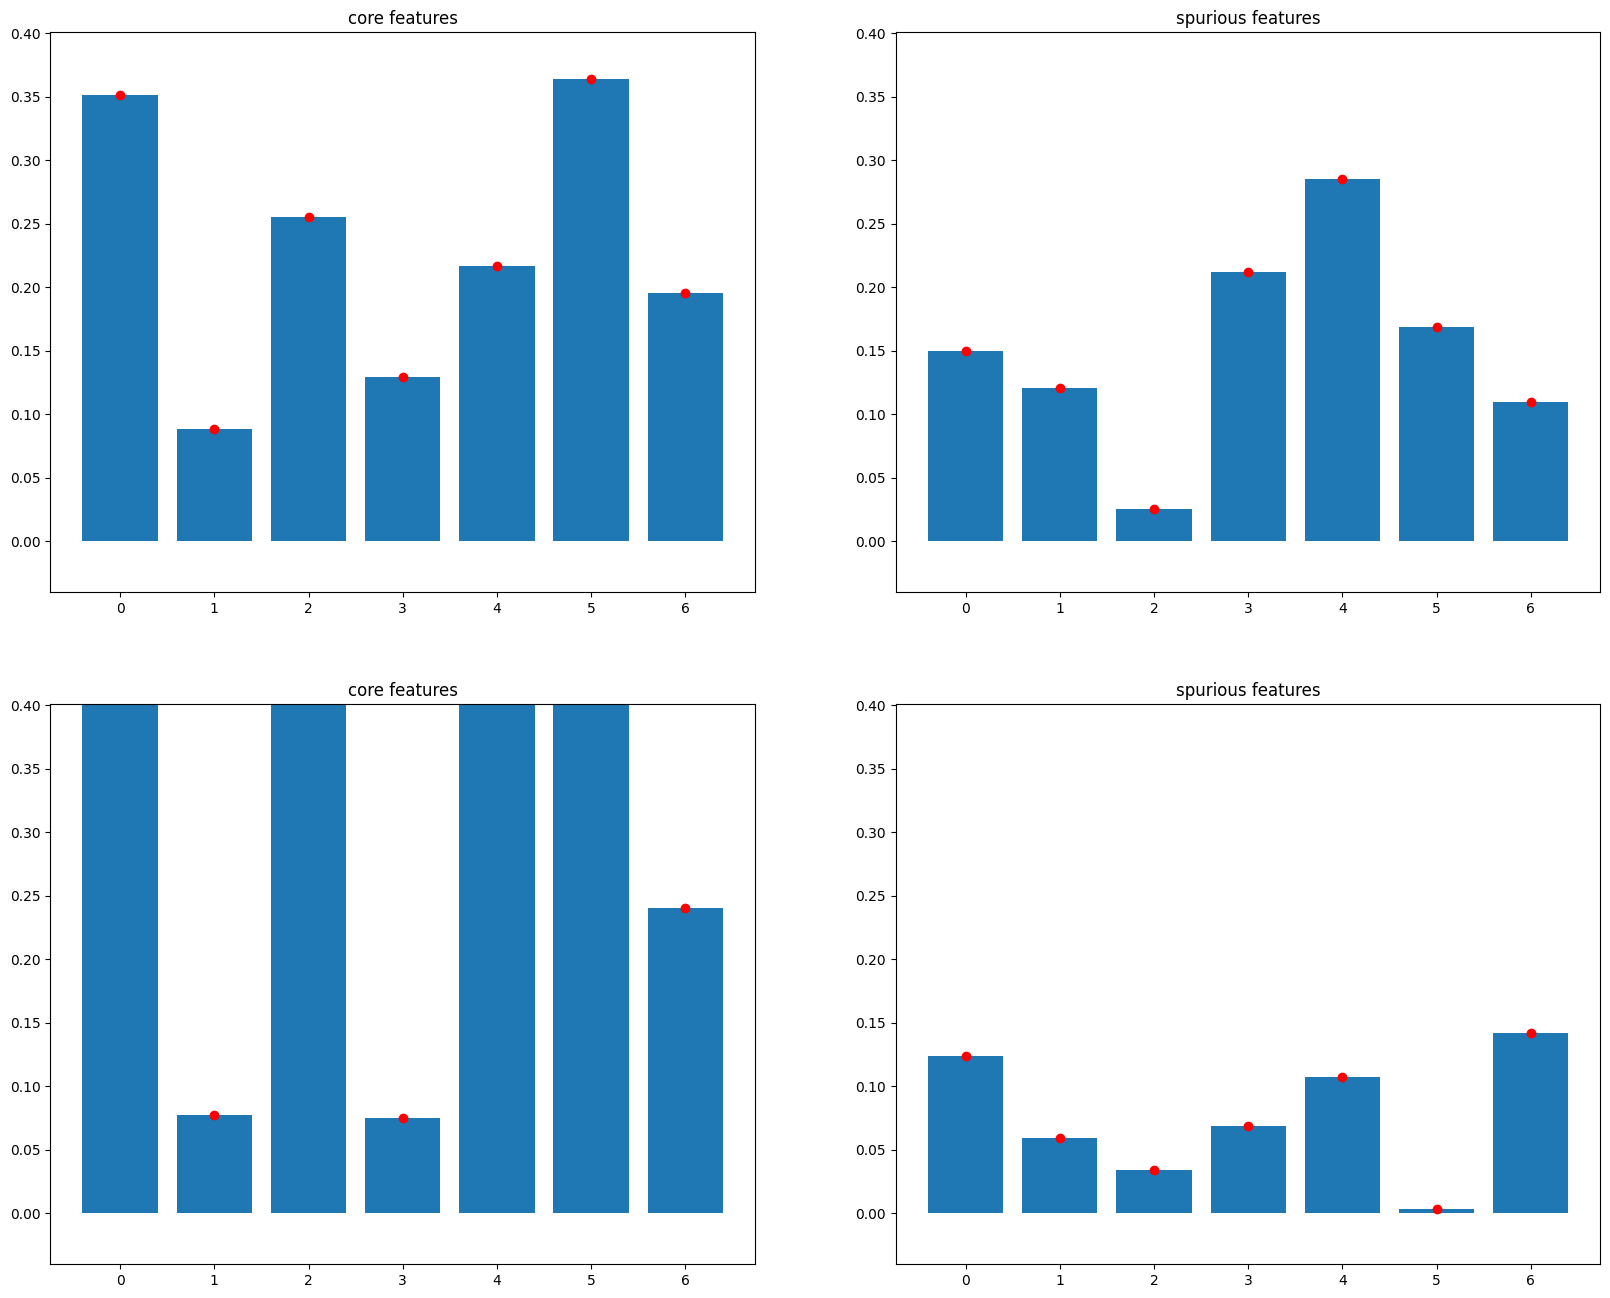

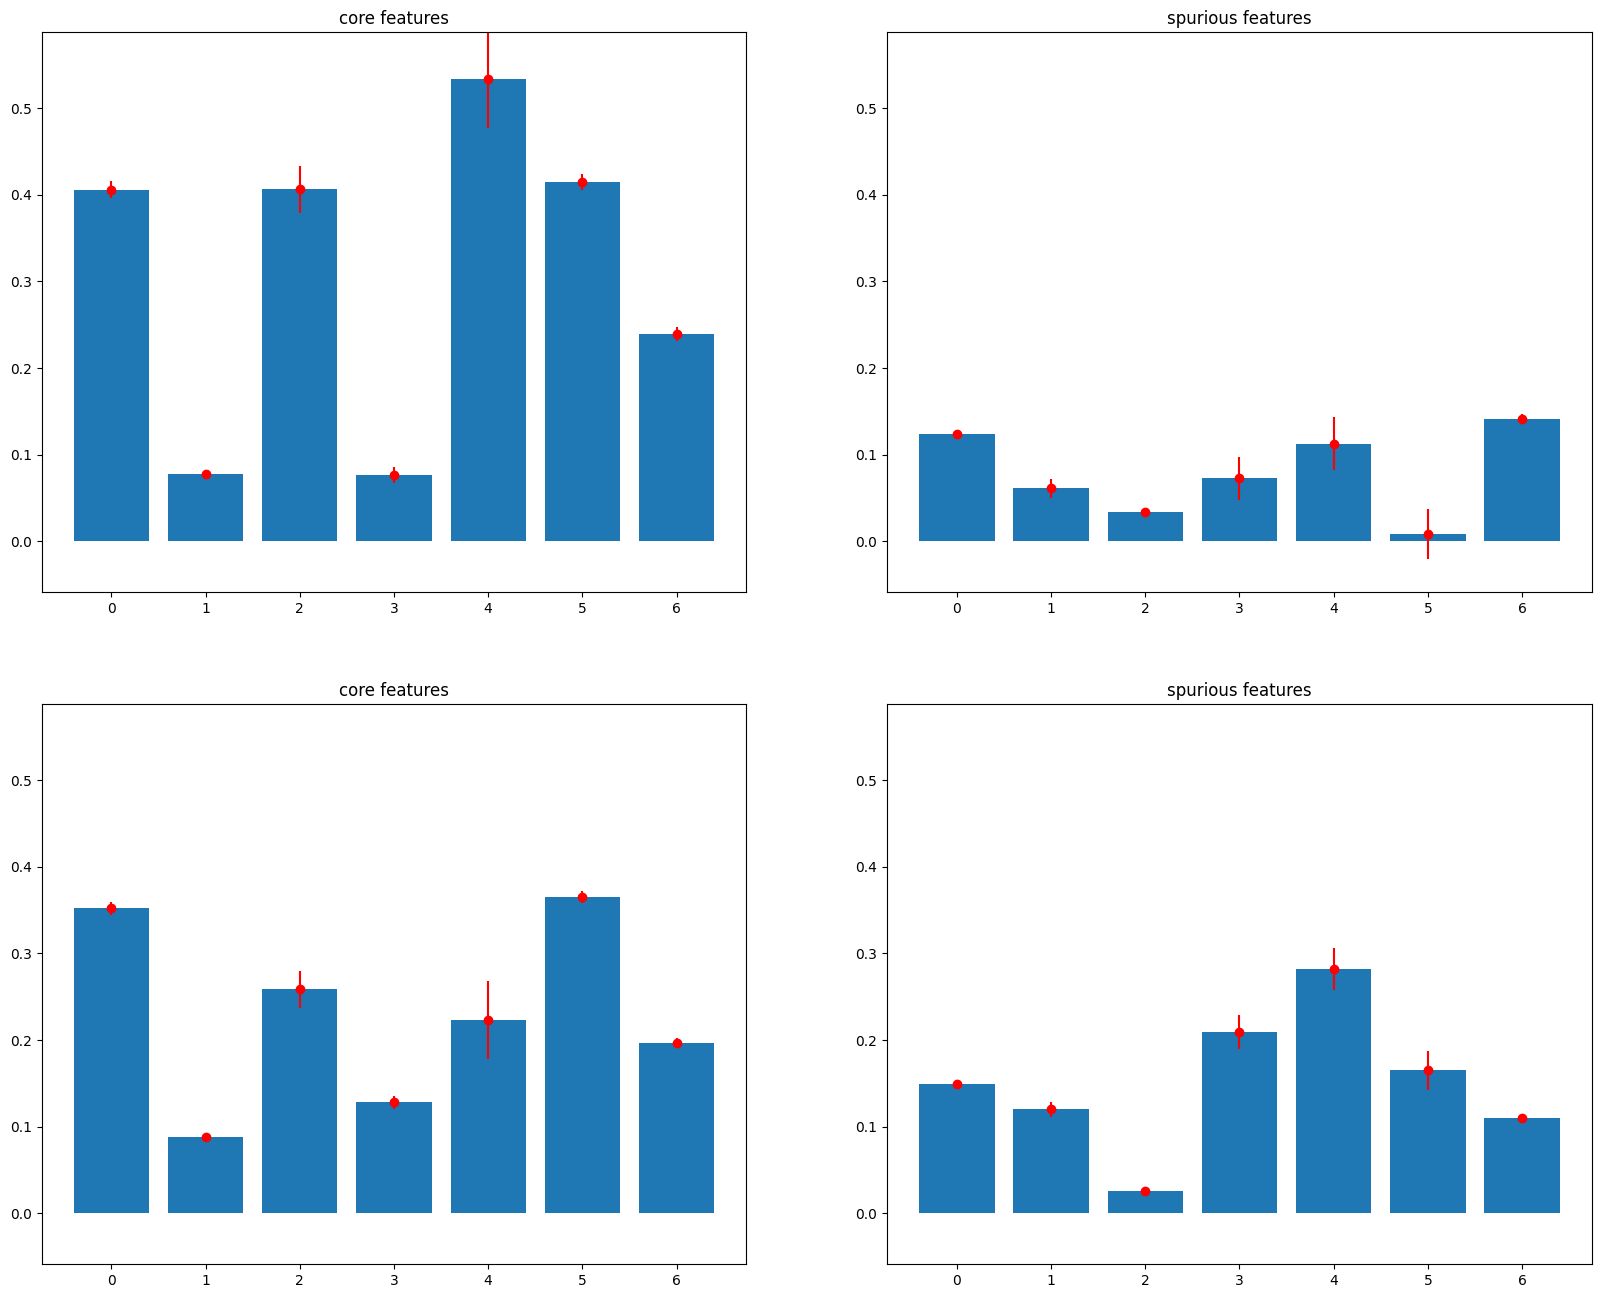

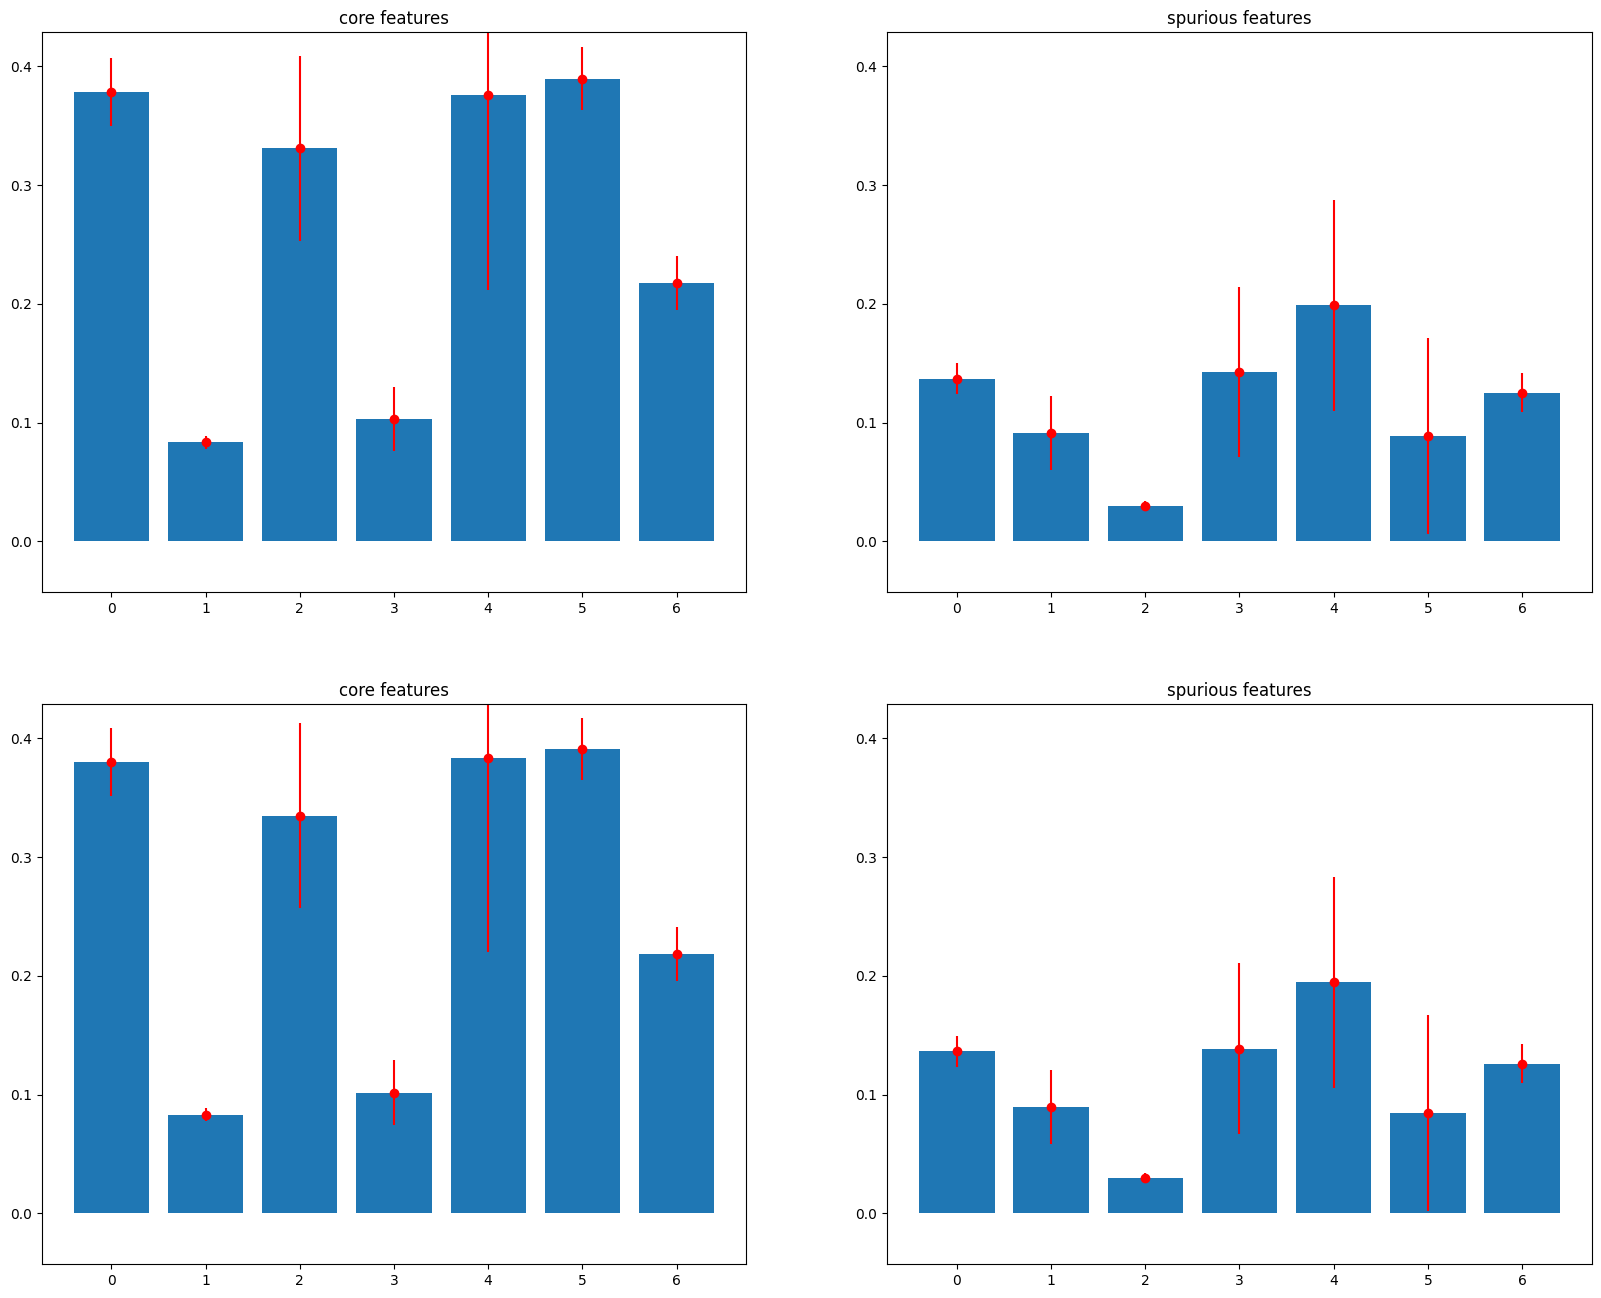

In [ ]:
for plot in ['maj', 'min', 'general']:
  fig = plt.figure(figsize = (2 * 10, 2 * 8))

  plt.subplot(2, 2, 1)
  y_value = maj_min_results(0, balanced_test_dataset, core_features, 'test', True, plot, None)

  plt.subplot(2, 2, 2)
  maj_min_results(0, balanced_test_dataset, sp_features, 'test', False, plot, y_value)

  plt.subplot(2, 2, 3)
  maj_min_results(1, balanced_test_dataset, core_features, 'test', True, plot, y_value)

  plt.subplot(2, 2, 4)
  maj_min_results(1, balanced_test_dataset, sp_features, 'test', False, plot, y_value)


# Make a group-balanced dataset

In [ ]:
threshold = np.Infinity
for cls in range(2):
  for sp in range(2):
    threshold = min(threshold, len(splitted_train_dataset[(cls, sp)][0]))
    print(f'group {cls, sp} size: ', len(splitted_train_dataset[(cls, sp)][0]))

group (0, 0) size:  10000
group (0, 1) size:  500
group (1, 0) size:  500
group (1, 1) size:  10000


In [ ]:
balanced_train_dataset = {}

for cls in range(2):
  for sp in range(2):
    ds = splitted_train_dataset[(cls, sp)]
    random_idx = random.sample(range(len(ds[0])), threshold)
    random.shuffle(random_idx)
    balanced_train_dataset[(cls, sp)] = [ds[0][random_idx], ds[1][random_idx], ds[2][random_idx], ds[3][random_idx]]

In [ ]:
for cls in range(2):
  for sp in range(2):
    print(f'group {cls, sp} size: ', len(balanced_train_dataset[(cls, sp)][0]))

group (0, 0) size:  500
group (0, 1) size:  500
group (1, 0) size:  500
group (1, 1) size:  500


# Labeling core features & spurious features

In [ ]:
# core features

cls_0_features = balanced_dataset[(0, 0)][0] + balanced_dataset[(0, 1)][0]
cls_1_features = balanced_dataset[(1, 0)][0] + balanced_dataset[(1, 1)][0]

cls_mean_0, cls_std_0 = torch.mean(cls_0_features, dim = 0), torch.std(cls_0_features, dim = 0)
cls_mean_1, cls_std_1 = torch.mean(cls_1_features, dim = 0), torch.std(cls_1_features, dim = 0)

cls_diff_mean = torch.abs(cls_mean_0 - cls_mean_1)
cls_sum_std = cls_std_0 + cls_std_1

def get_core_features(alpha):
  core_features = torch.argwhere(cls_diff_mean > alpha * cls_sum_std).squeeze()
  return core_features

In [ ]:
# spurious features

sp_0_features = balanced_dataset[(0, 0)][0] + balanced_dataset[(1, 0)][0]
sp_1_features = balanced_dataset[(0, 1)][0] + balanced_dataset[(1, 1)][0]

sp_mean_0, sp_std_0 = torch.mean(sp_0_features, dim = 0), torch.std(sp_0_features, dim = 0)
sp_mean_1, sp_std_1 = torch.mean(sp_1_features, dim = 0), torch.std(sp_1_features, dim = 0)

sp_diff_mean = torch.abs(sp_mean_0 - sp_mean_1)
sp_sum_std = sp_std_0 + sp_std_1

def get_sp_features(alpha):
  sp_features = torch.argwhere(sp_diff_mean > alpha * sp_sum_std).squeeze()
  return sp_features

# Choosing the best core features & spurious features

In [ ]:
# Load datasets for training with logistic regression model

train_idx, test_idx = train_test_split(np.arange(len(features)), test_size=0.2)
train_emb, train_label, train_group = features[train_idx], labels[train_idx], groups[train_idx]
train_weights = weights[train_idx]
train_sp = train_group - 2 * train_label

# Load test dataset
test_emb, test_label, test_group = features[test_idx], labels[test_idx], groups[test_idx]
test_weights = weights[test_idx]
test_sp = test_group - 2 * test_label

# test_splitted_dataset = group_split(test_dataset, test_weights)

NameError: name 'features' is not defined

In [ ]:
# Choose best features based the label prediction accuracy on test dataset

def get_best_features(is_core = True, test_features = False):
  best_features = None
  best_test_accuracy = 0

  with tqdm(iterable = range(1, 101), total = len(range(1, 101))) as pbar:
    for alpha in pbar:
      alpha /= 100

      if is_core:
        selected_features = get_core_features(alpha)
      else:
        selected_features = get_sp_features(alpha)

      if len(selected_features) == 0:
        continue

      filtered_train_emb = train_emb[:, selected_features]

      cls = LogisticRegression(max_iter = 500)
      if is_core:
        cls.fit(filtered_train_emb, train_label)
        acc = accuracy_score(cls.predict(test_emb[:, selected_features]), test_label)
      else:
        cls.fit(filtered_train_emb, train_sp)
        acc = accuracy_score(cls.predict(test_emb[:, selected_features]), test_sp)

      if acc > best_test_accuracy:
        best_test_accuracy = acc
        best_features = selected_features.clone()

  feature_type = 'core' if is_core else 'spurious'
  print(f'the best selected {feature_type} features have the test accuracy of {best_test_accuracy * 100:.2f}%')
  if test_features:
    cls = LogisticRegression(max_iter = 500)
    if is_core:
      cls.fit(train_emb[:, best_features], train_sp)
      other_acc = accuracy_score(cls.predict(test_emb[:, best_features]), test_sp)
    else:
      try:
        cls.fit(train_emb[:, best_features], train_label)
        other_acc = accuracy_score(cls.predict(test_emb[:, best_features]), test_label)
      except:
        print(selected_features)
        raise ValueError()
    print(f'the test accuracy of selected {feature_type} features with opposite labels is: {other_acc * 100:.2f}%')

  return best_features


In [ ]:
core_features = get_best_features(True, True)

100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


the best selected core features have the test accuracy of 100.00%
the test accuracy of selected core features with opposite labels is: 50.02%


In [ ]:
sp_features = get_best_features(is_core = False, test_features = True)

100%|██████████| 100/100 [00:00<00:00, 2215.02it/s]

the best selected spurious features have the test accuracy of 51.49%
the test accuracy of selected spurious features with opposite labels is: 100.00%


In [ ]:
print(f'len core features: {len(core_features)}')
print(f'len spurious features: {len(sp_features)}')

len core features: 8
len spurious features: 2


In [ ]:
jaccard = len(np.intersect1d(core_features, sp_features)) / len(np.union1d(core_features, sp_features))
print(f'jaccard score between select core features and selected spurious features is {jaccard}')

jaccard score between select core features and selected spurious features is 0.25


In [ ]:
irrelevant_features = np.setdiff1d(torch.arange(14), np.union1d(core_features, sp_features))

In [ ]:
core_features = torch.arange(7)
sp_features = torch.arange(7, 14)
irrelevant_features = core_features

# Create Visualizations (aggregated features)

In [ ]:
def plot_results(cls, group, balanced_dataset, y_value = None):
  dataset = balanced_dataset[(cls, group)][3]

  core_mean, core_std = torch.mean(dataset[:, core_features.squeeze()].reshape(-1)), torch.std(dataset[:, core_features.squeeze()].reshape(-1))
  sp_mean, sp_std = torch.mean(dataset[:, sp_features.squeeze()].reshape(-1)), torch.std(dataset[:, core_features.squeeze()].reshape(-1))
  irrelevant_mean, irrelevant_std = torch.mean(dataset[:, irrelevant_features.squeeze()].reshape(-1)), torch.std(dataset[:, core_features.squeeze()].reshape(-1))

  '''
  core_mean, core_std = torch.mean(core), torch.std(core)
  sp_mean, sp_std = torch.mean(sp), torch.std(sp)
  irrelevant_mean, irrelevant_std = torch.mean(irrelevant), torch.std(irrelevant)
  '''
  x_list = ['core', 'spurious', 'irrelevant']
  group_type = 'majority' if cls == group else 'minority'
  plt.title(f'{arg_softmax} {arg_cam} weight visualization for class {cls}, group {group}, {group_type}')
  plt.bar(x_list, [core_mean, sp_mean, irrelevant_mean])
  plt.errorbar(x_list, [core_mean, sp_mean, irrelevant_mean], yerr=[core_std, sp_std, irrelevant_std], fmt="o", color="r")
  plt.xticks(range(len(x_list)), x_list, rotation='vertical')

  os.makedirs(f'/content/results/WB/aggregated features/{arg_cam}/{arg_softmax}/{arg_dropout}', exist_ok = True)
  plt.savefig(f'/content/results/WB/aggregated features/{arg_cam}/{arg_softmax}/{arg_dropout}/plot_class{cls}.png')

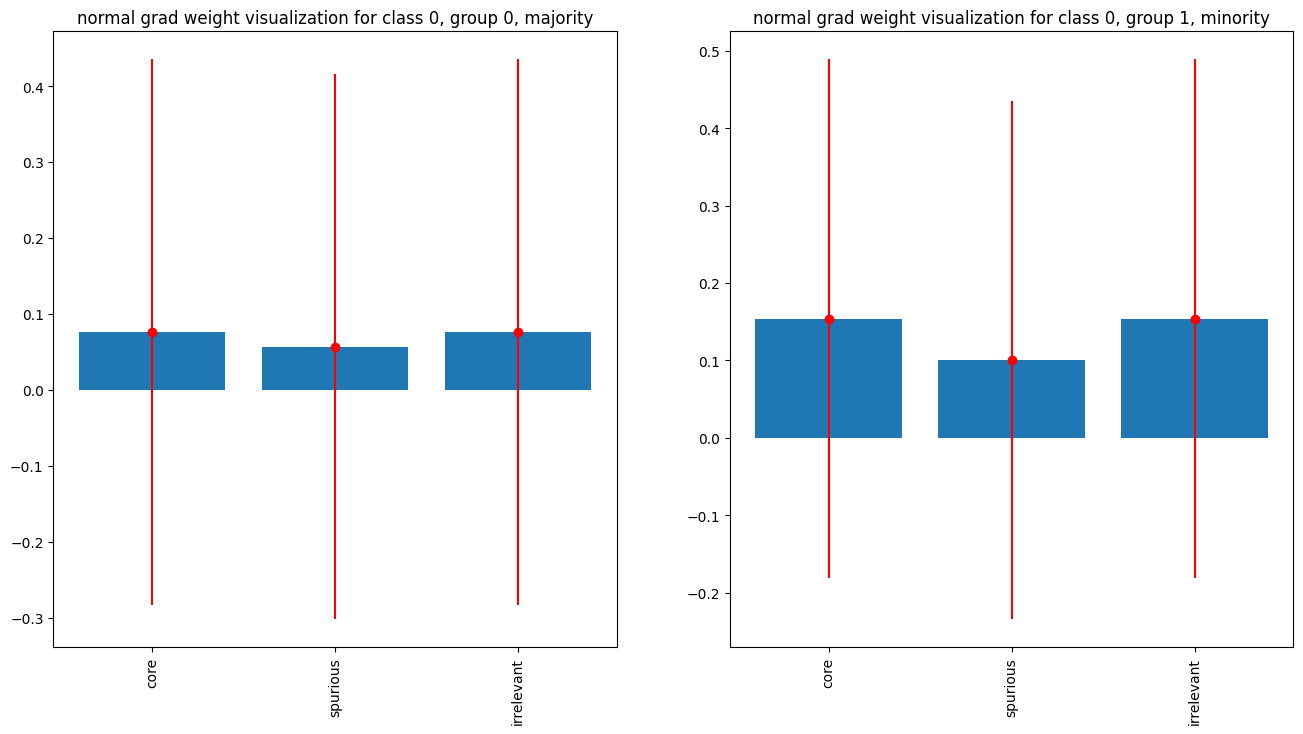

In [ ]:
fig = plt.figure(figsize = (2 * 8, 1 * 8))

plt.subplot(1, 2, 1)
plot_results(0, 0, balanced_dataset)

plt.subplot(1, 2, 2)
plot_results(0, 1, balanced_dataset)


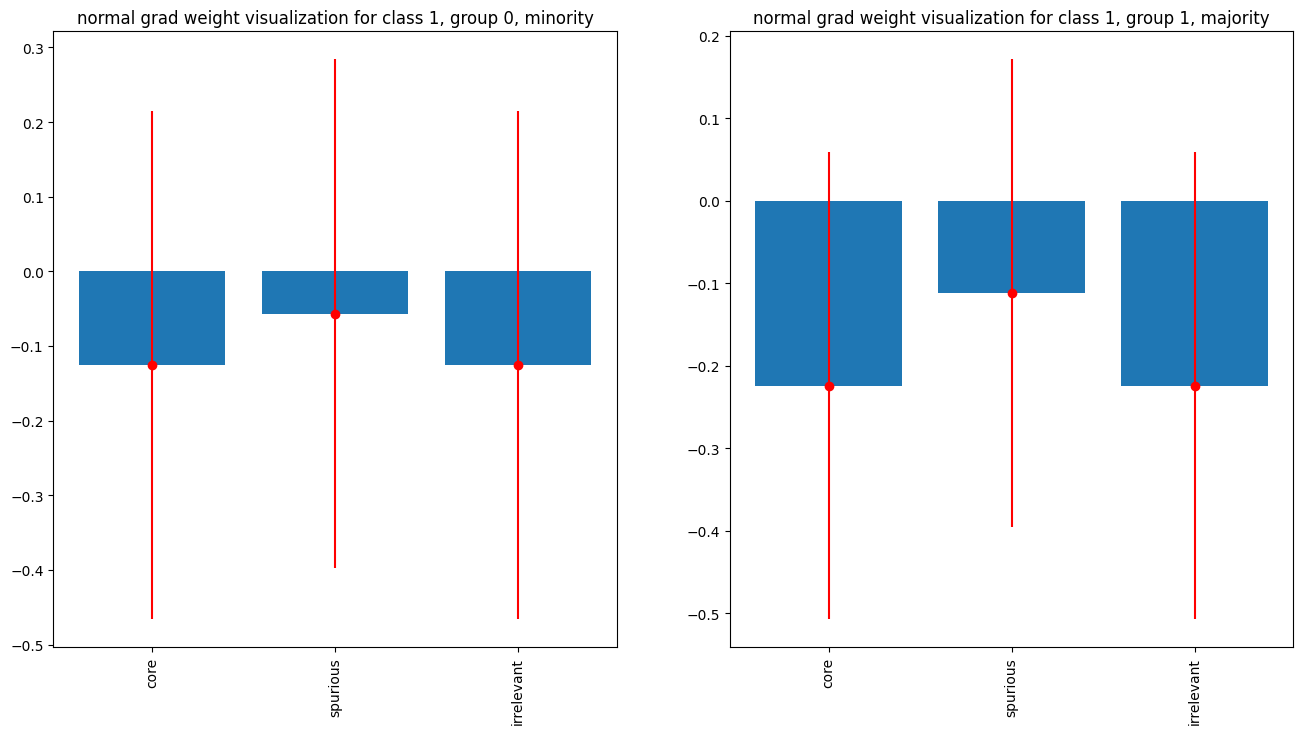

In [ ]:
fig = plt.figure(figsize = (2 * 8, 1 * 8))

plt.subplot(1, 2, 1)
plot_results(1, 0, balanced_dataset)

plt.subplot(1, 2, 2)
plot_results(1, 1, balanced_dataset)

# Feature wise visualization

In [ ]:
def maj_min_results(cls, balanced_dataset, features, dataset_type, is_core, mode = 'maj', y_value = None):
  maj_dataset = balanced_dataset[(cls, cls)][3]
  min_dataset = balanced_dataset[(cls, 1 - cls)][3]

  if mode == 'general':
    dataset = torch.cat((maj_dataset, min_dataset))
  elif mode == 'maj':
    dataset = maj_dataset
  elif mode == 'min':
    dataset = min_dataset
  elif mode == 'all_data':
    dataset = torch.tensor([])
    for cls in range(2):
      for sp in range(2):
        dataset = torch.cat((dataset, balanced_dataset[cls, sp][3]))
  else:
    raise ValueError(f'mode value {mode} is incorrect')

  avg_features, std_features = torch.mean(dataset[:, features], dim = 0).squeeze(), torch.std(dataset[:, features], dim = 0).squeeze()

  x_axis = np.arange(len(features))

  feature_type = 'core' if is_core else 'spurious'
  if mode == 'all_data':
    cls = ''
  else:
    cls = f'weight class {cls}'


  ds_type = {'train': 'training data (sp rate: 95%)', 'test': 'balanced validation set'}
  p_types = {'maj': 'majority', 'min': 'minority', 'general': 'both maj & min', 'all_data': 'all groups'}
  plot_type = p_types[mode]

  plt.title(f'{plot_type} average {arg_softmax} {arg_cam} {cls} visualization on {feature_type} {ds_type[dataset_type]}')
  plt.bar(x_axis, avg_features)
  plt.errorbar(x_axis, avg_features, yerr=std_features, fmt="o", color="r")

  if y_value is None:
    y_value = 1.1 * torch.amax(avg_features)

  plt.ylim([-y_value / 10, y_value])

  os.makedirs(f'/content/results/custom dataset/feature-wise visualizations/{arg_cam}/{arg_softmax}/{arg_dropout}/{dataset_type}', exist_ok = True)
  plt.savefig(f'/content/results/custom dataset/feature-wise visualizations/{arg_cam}/{arg_softmax}/{arg_dropout}/{dataset_type}/plot_{mode}.png')


  return y_value

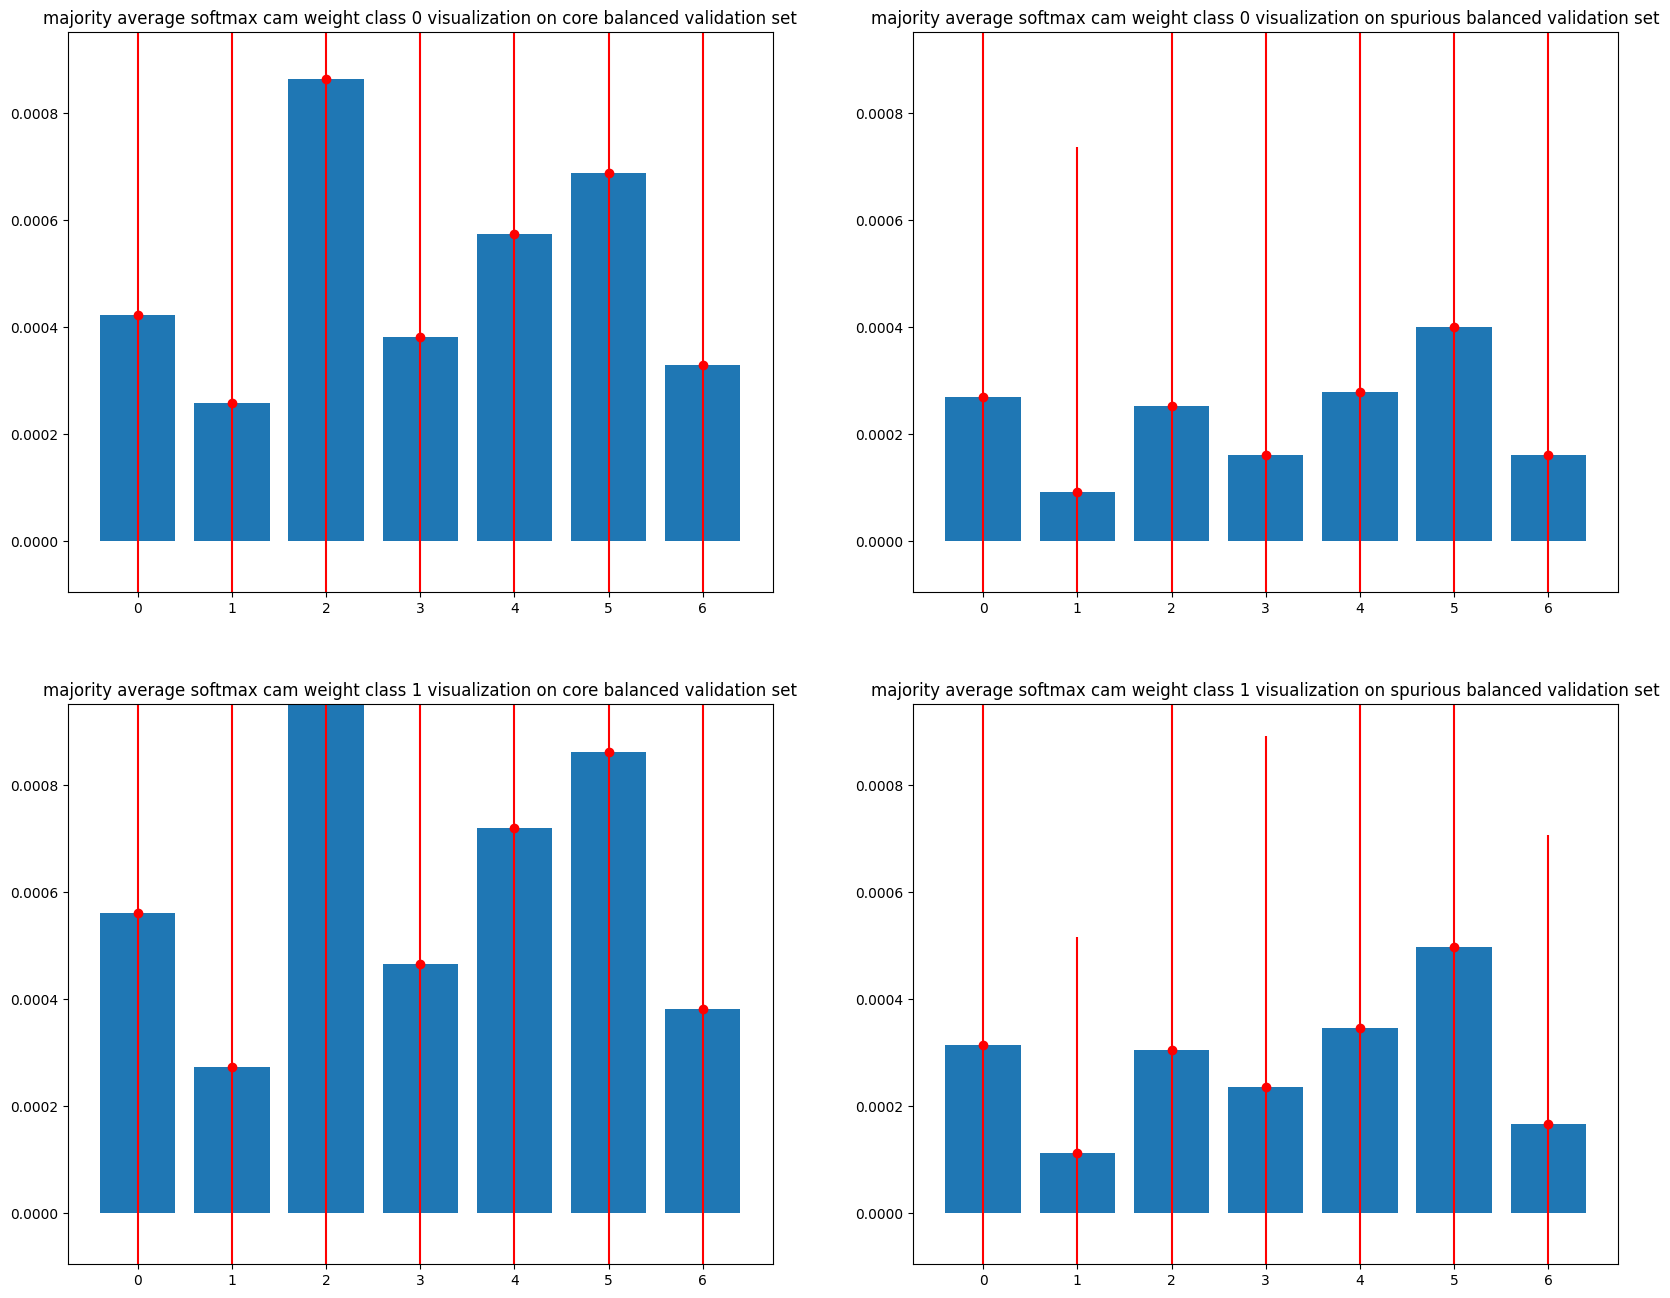

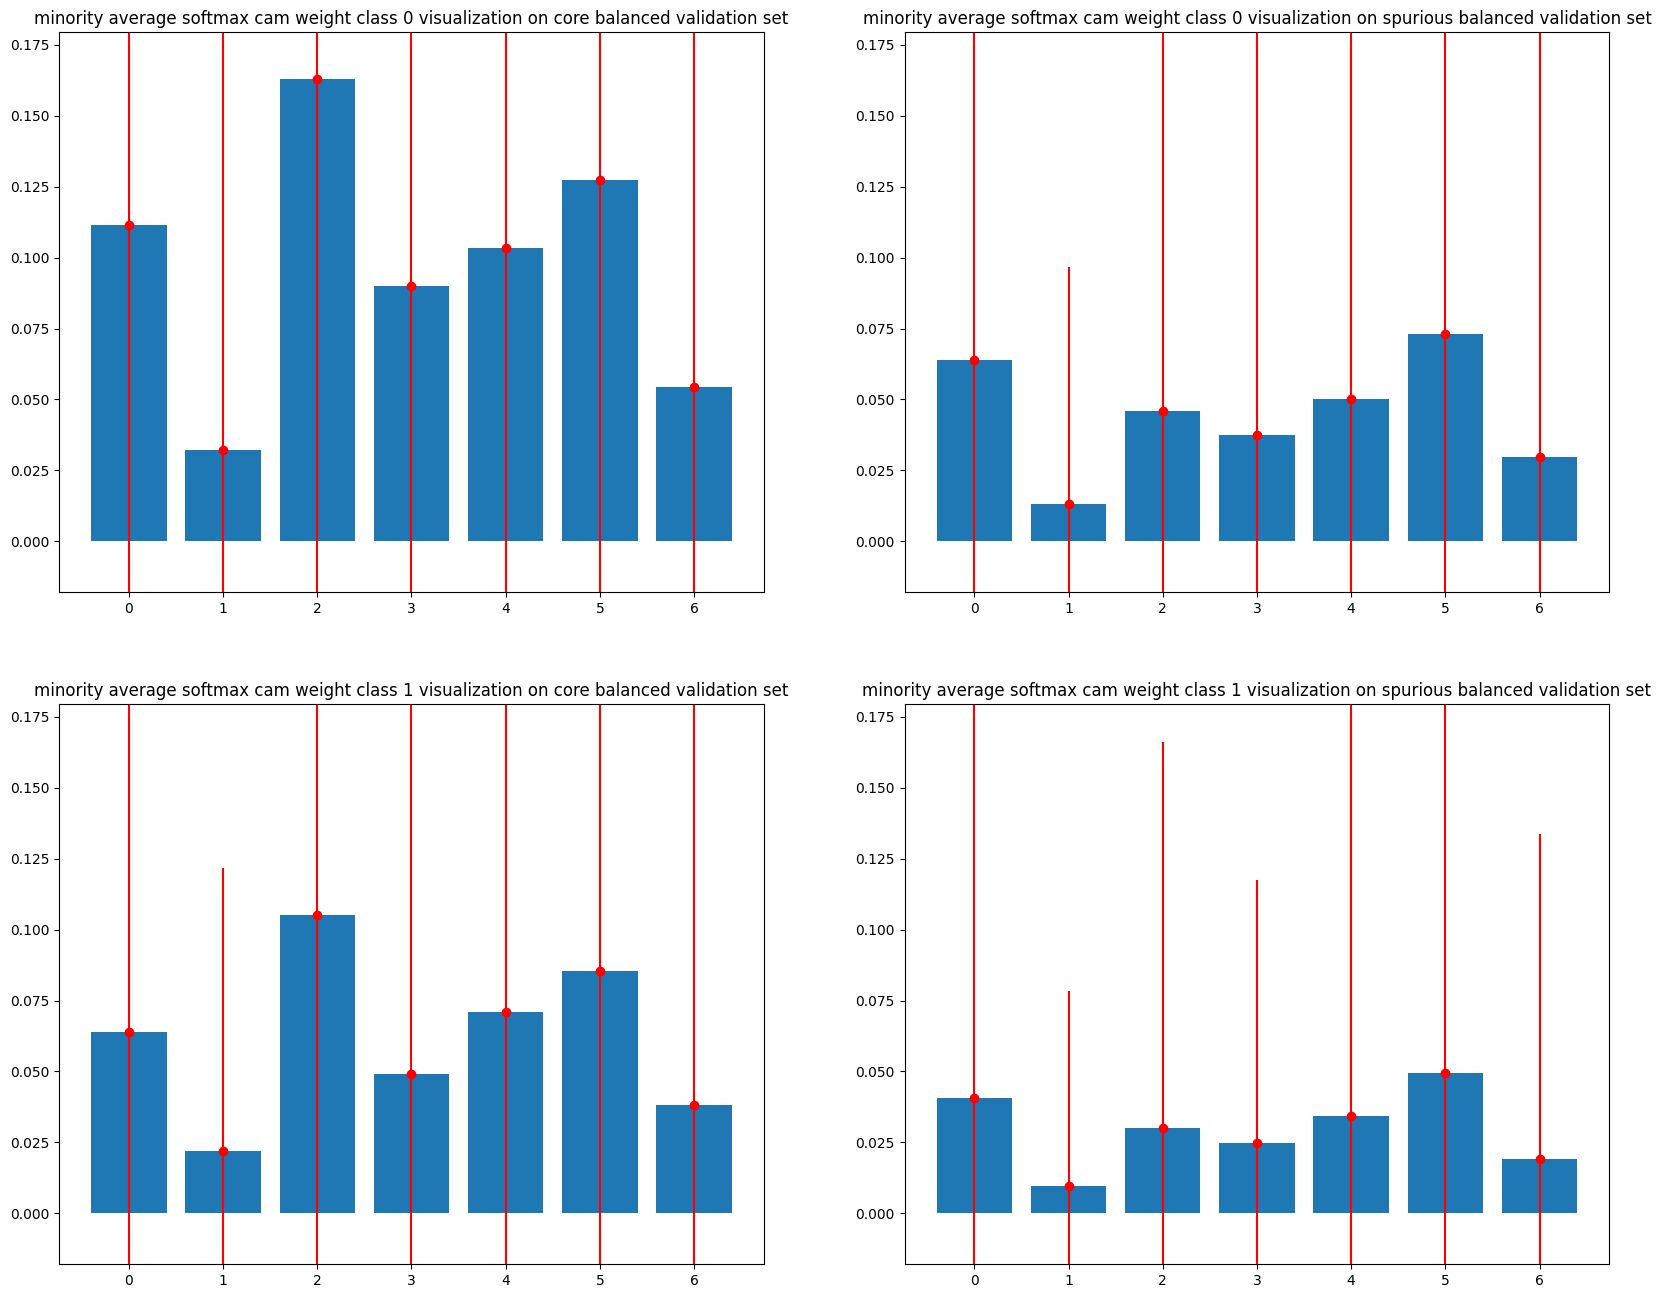

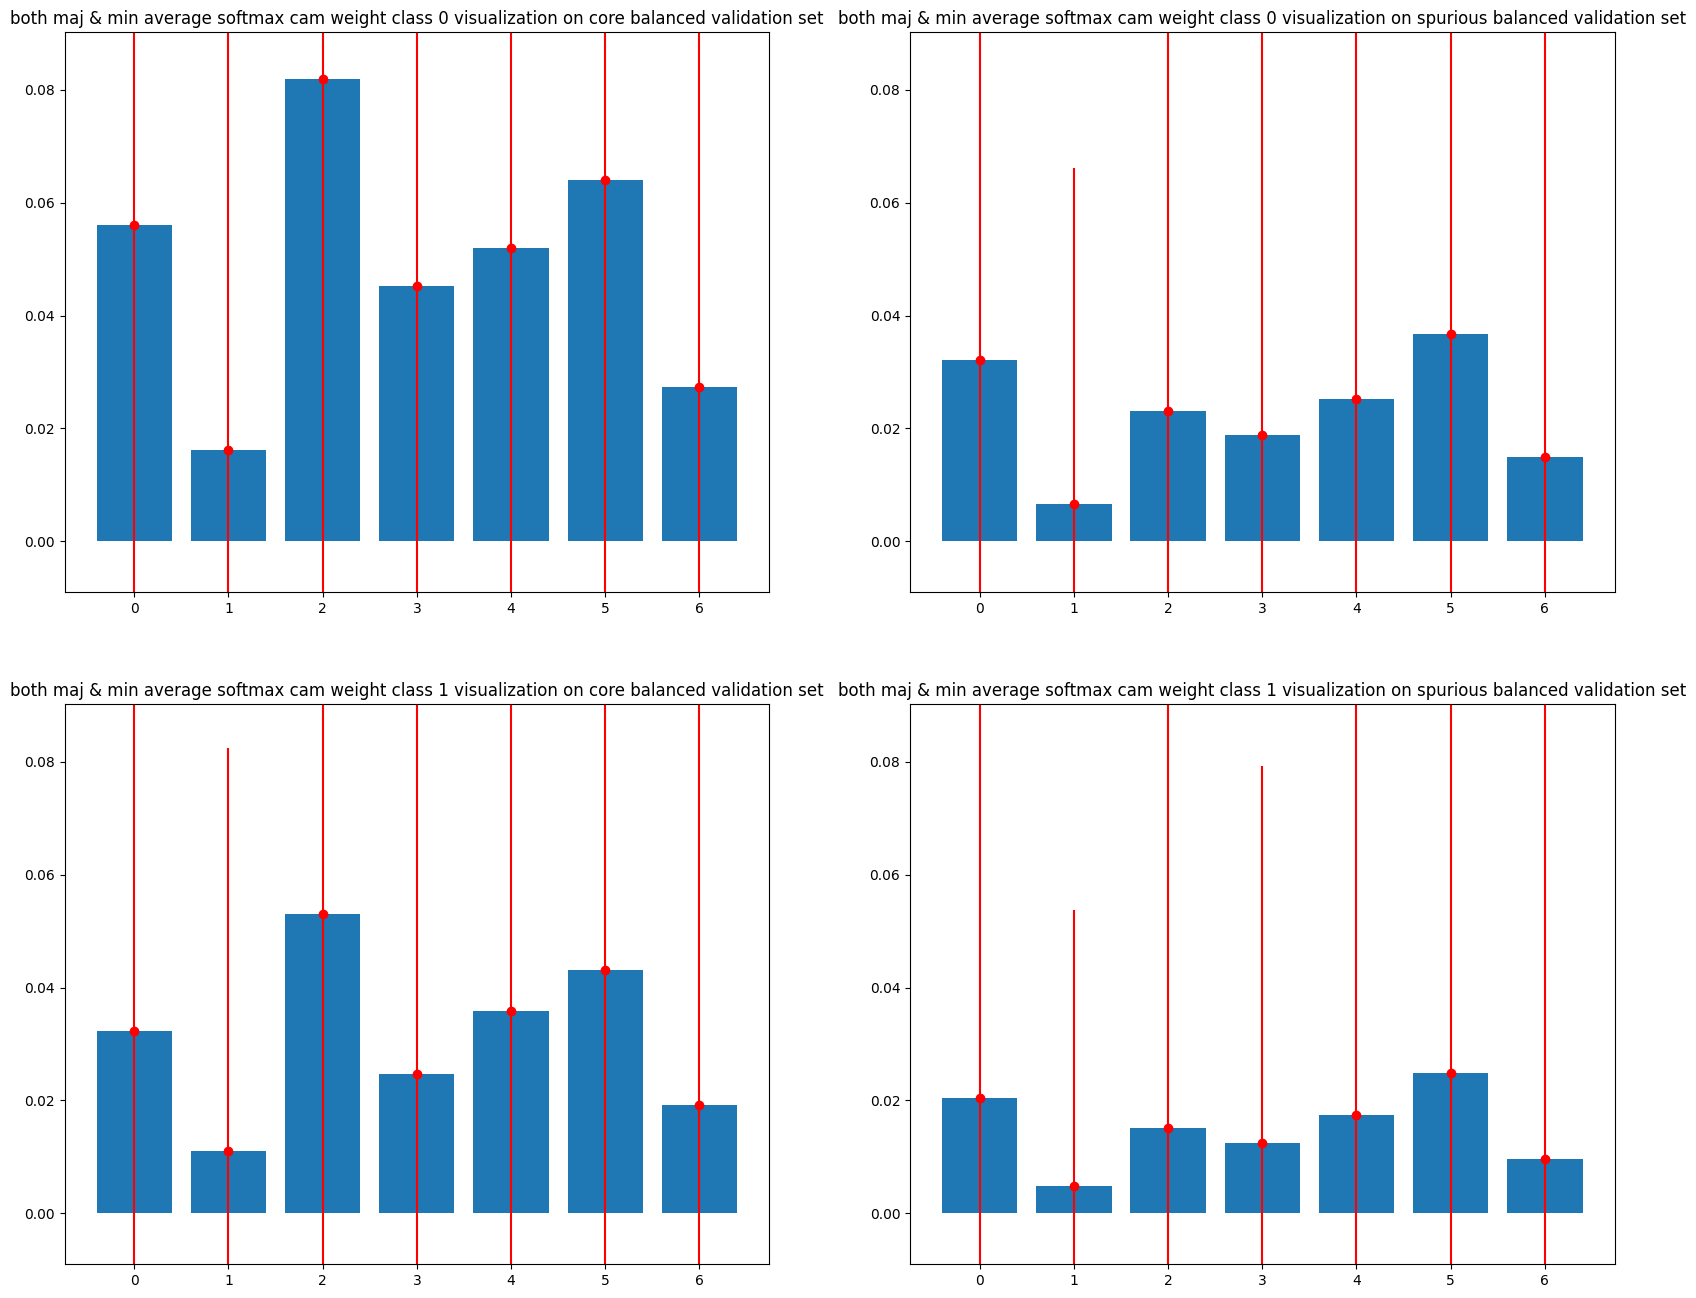

In [ ]:
for plot in ['maj', 'min', 'general']:
  fig = plt.figure(figsize = (2 * 10, 2 * 8))

  plt.subplot(2, 2, 1)
  y_value = maj_min_results(0, balanced_test_dataset, core_features, 'test', True, plot, None)

  plt.subplot(2, 2, 2)
  maj_min_results(0, balanced_test_dataset, sp_features, 'test', False, plot, y_value)

  plt.subplot(2, 2, 3)
  maj_min_results(1, balanced_test_dataset, core_features, 'test', True, plot, y_value)

  plt.subplot(2, 2, 4)
  maj_min_results(1, balanced_test_dataset, sp_features, 'test', False, plot, y_value)


tensor(0.0742)

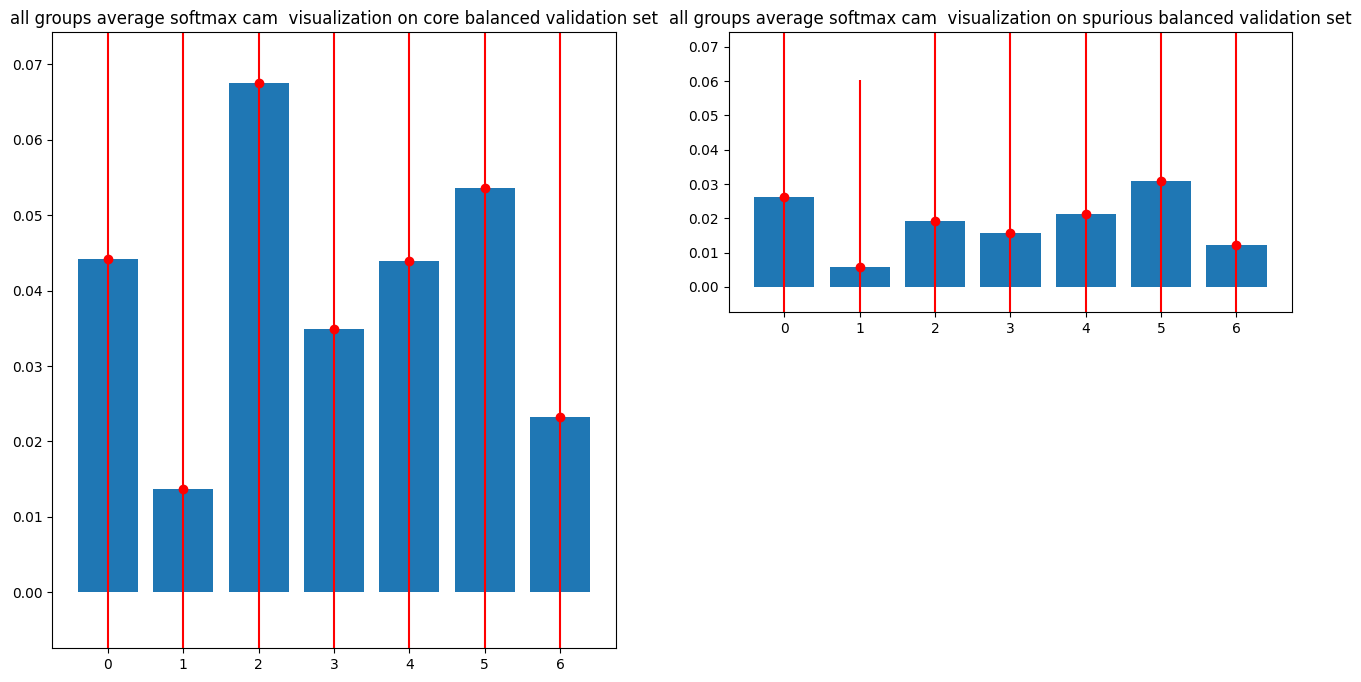

In [ ]:
fig = plt.figure(figsize = (2 * 8, 1 * 8))

plt.subplot(1, 2, 1)
y_value = maj_min_results(0, balanced_test_dataset, core_features, 'test', True, 'all_data', None)

plt.subplot(2, 2, 2)
maj_min_results(0, balanced_test_dataset, sp_features, 'test', False, 'all_data', y_value)

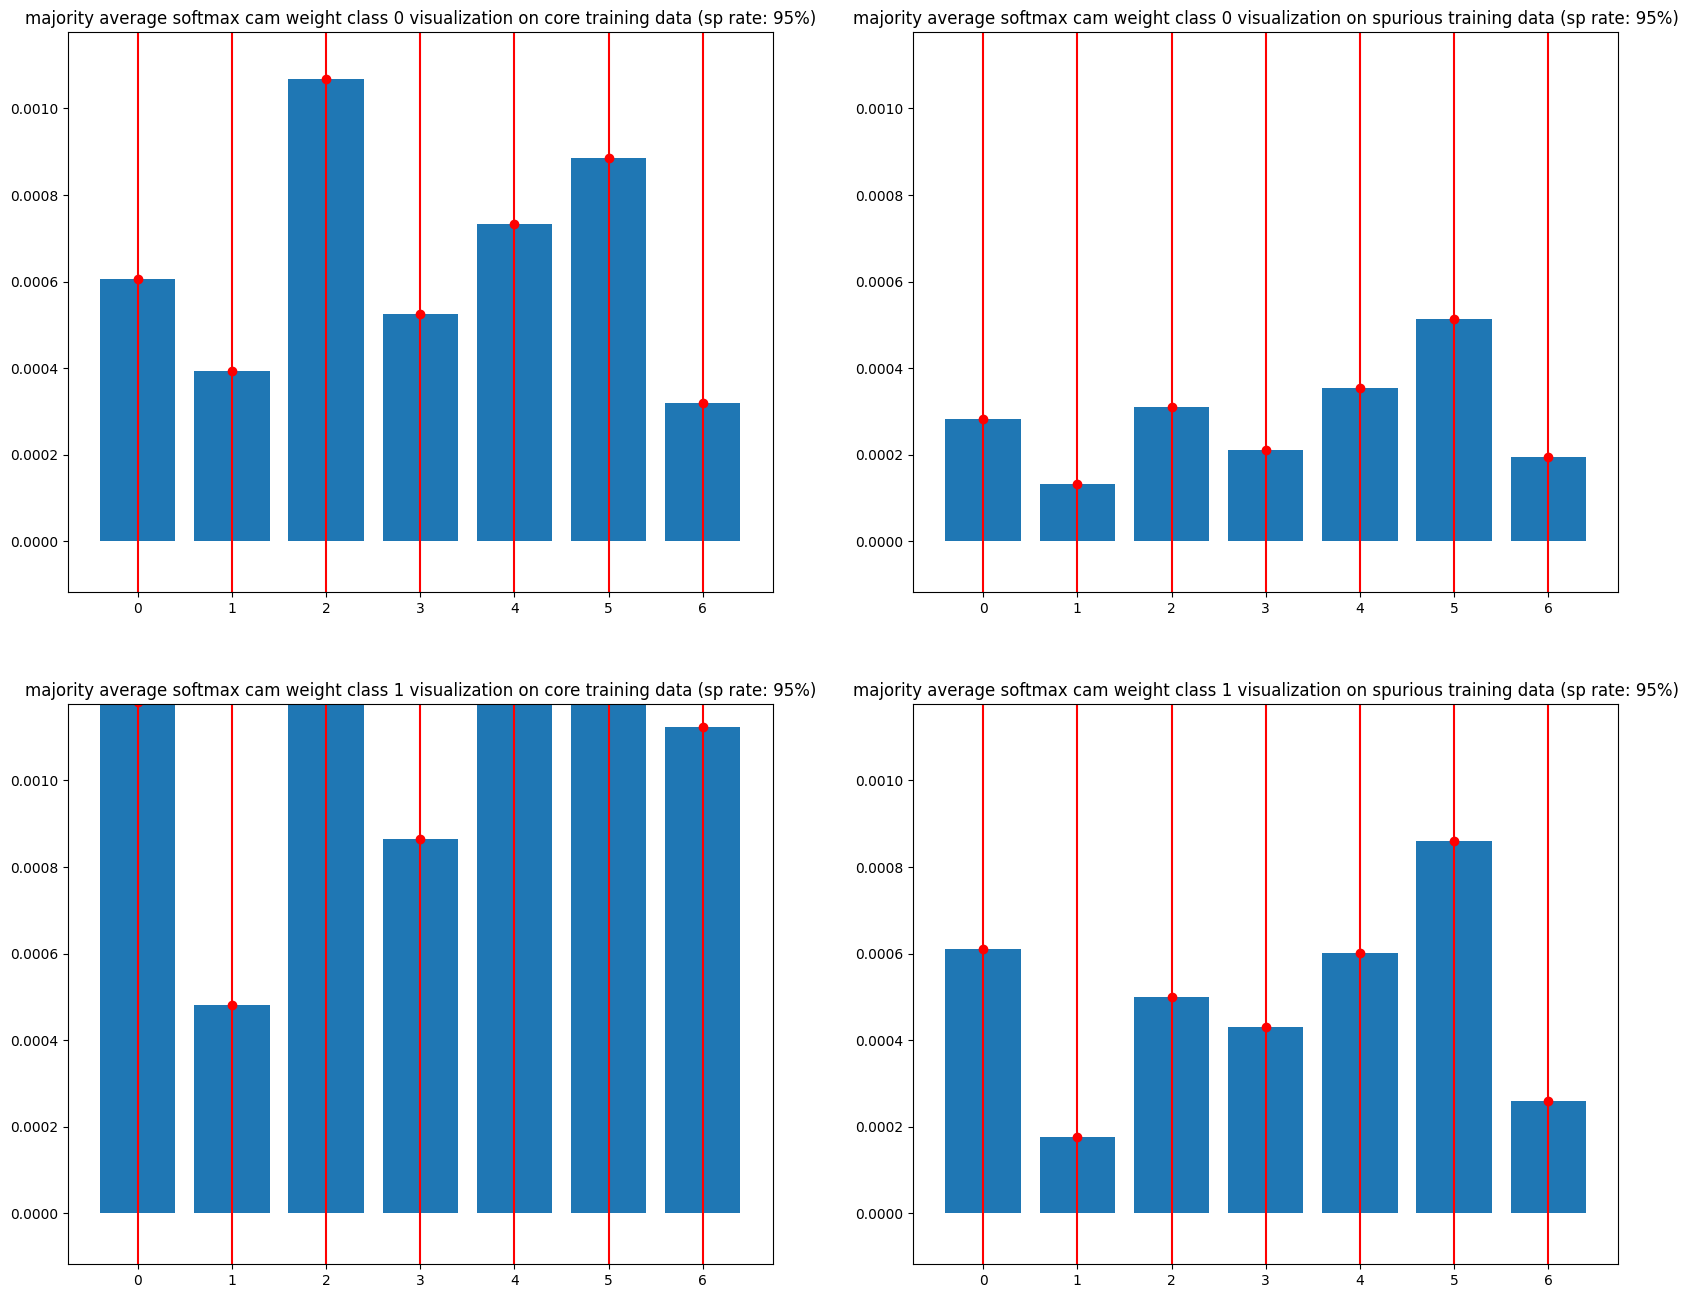

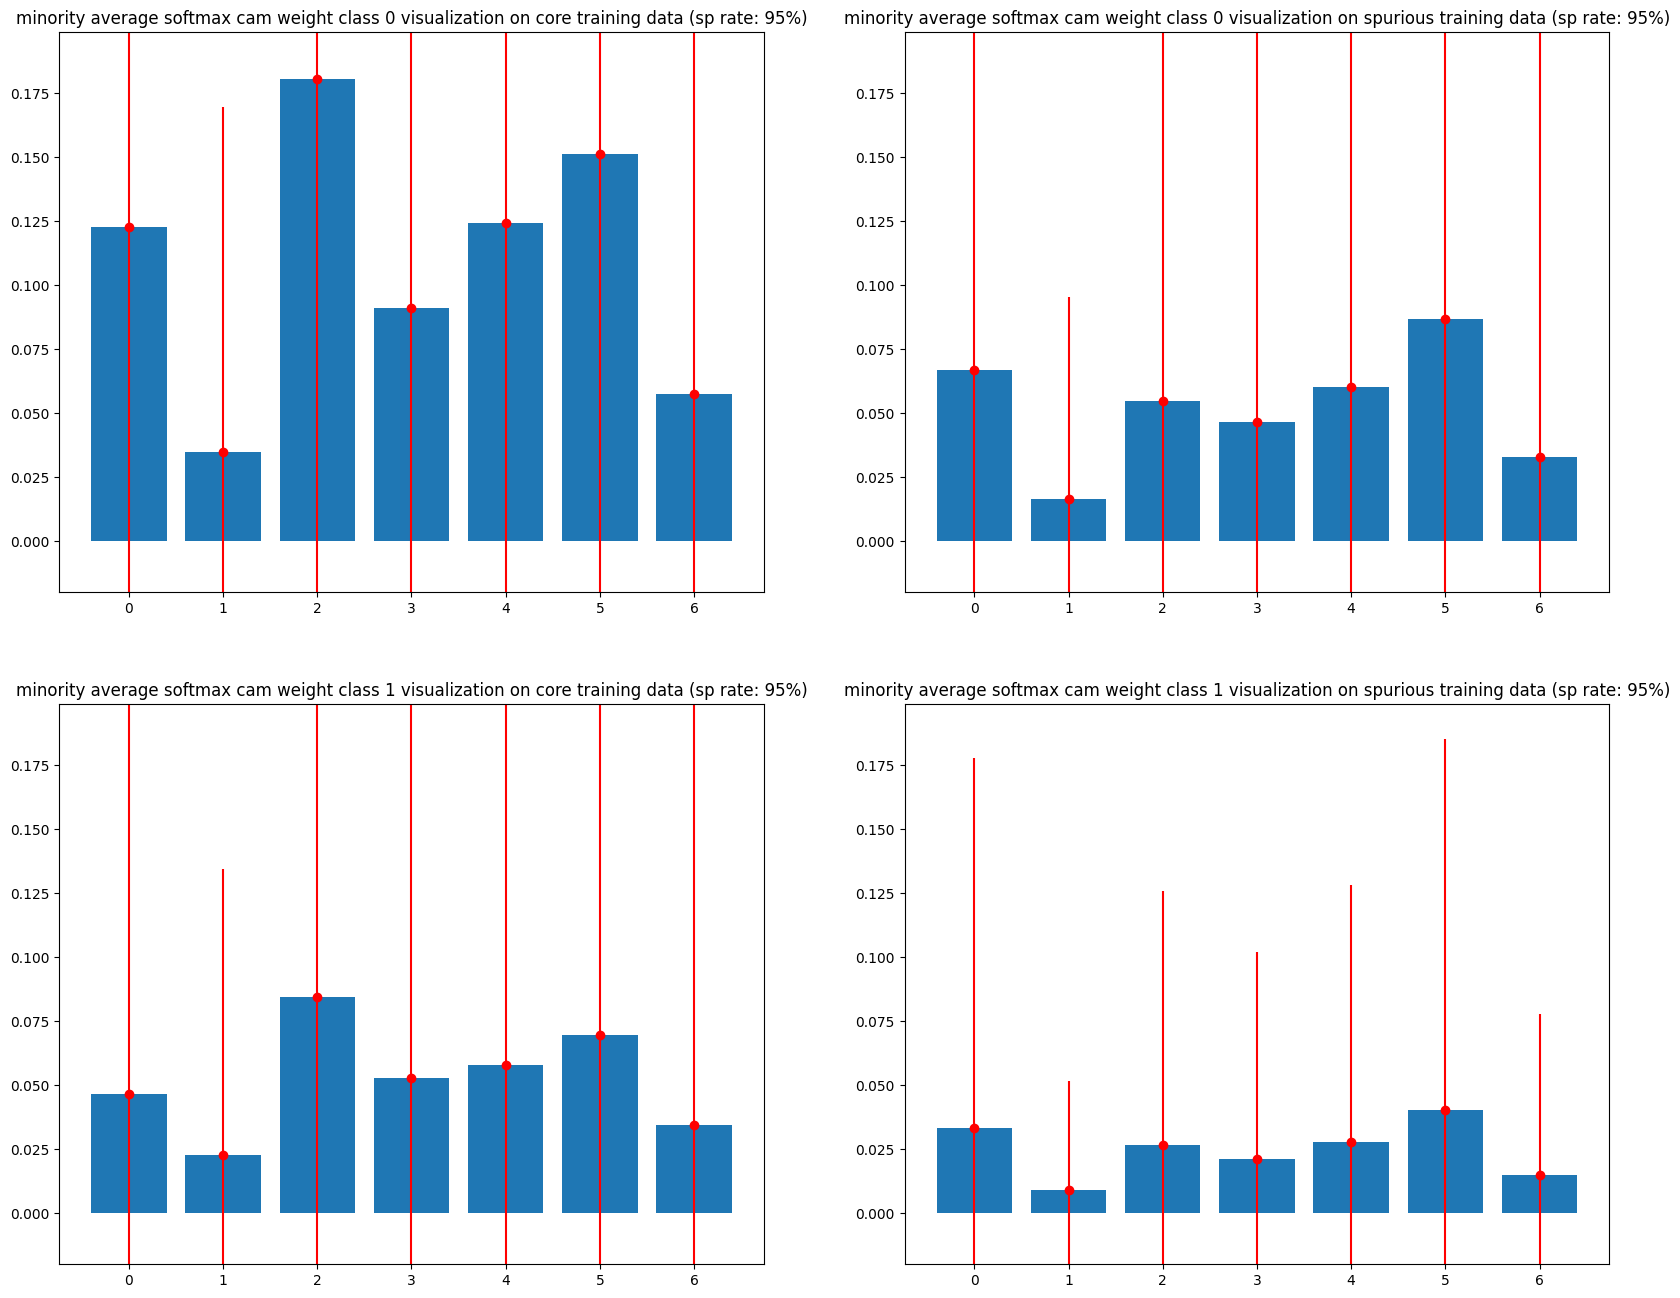

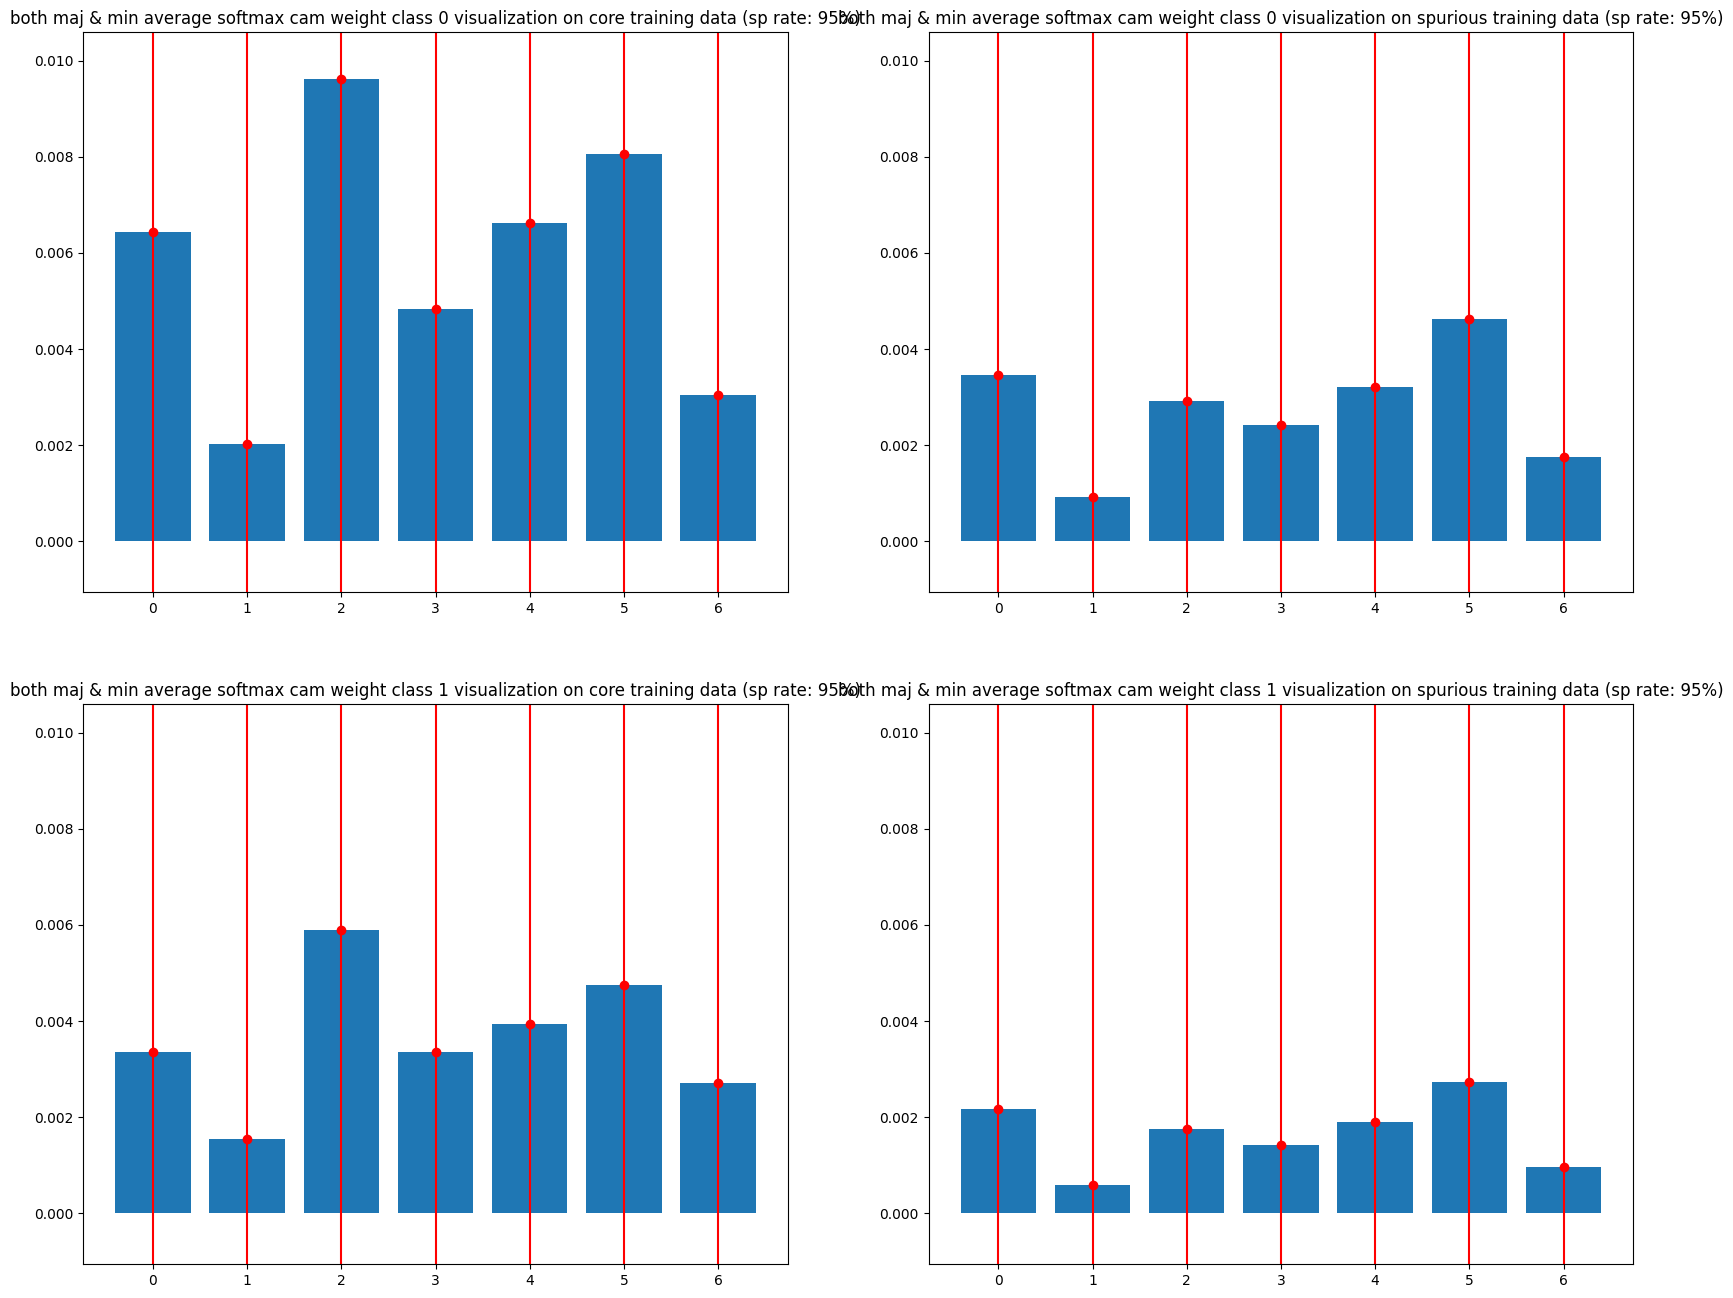

In [ ]:
for plot in ['maj', 'min', 'general']:
  fig = plt.figure(figsize = (2 * 10, 2 * 8))

  plt.subplot(2, 2, 1)
  y_value = maj_min_results(0, splitted_train_dataset, core_features, 'train', True, plot, None)

  plt.subplot(2, 2, 2)
  maj_min_results(0, splitted_train_dataset, sp_features, 'train', False, plot, y_value)

  plt.subplot(2, 2, 3)
  maj_min_results(1, splitted_train_dataset, core_features, 'train', True, plot, y_value)

  plt.subplot(2, 2, 4)
  maj_min_results(1, splitted_train_dataset, sp_features, 'train', False, plot, y_value)


tensor(0.0085)

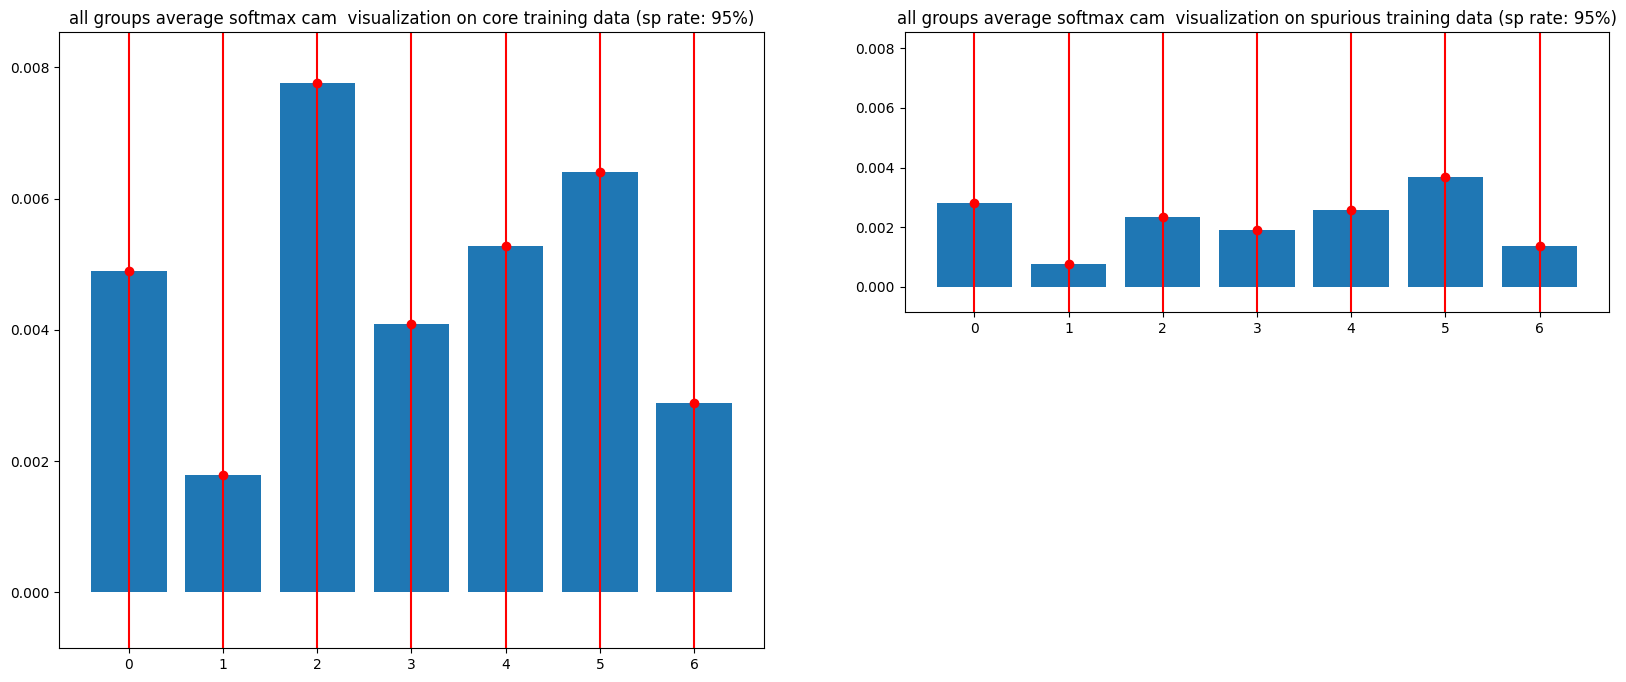

In [ ]:
fig = plt.figure(figsize = (2 * 10, 1 * 8))

plt.subplot(1, 2, 1)
y_value = maj_min_results(0, splitted_train_dataset, core_features, 'train', True, 'all_data', None)

plt.subplot(2, 2, 2)
maj_min_results(0, splitted_train_dataset, sp_features, 'train', False, 'all_data', y_value)

In [ ]:
# !rm -r /content/results/

In [ ]:
!zip -r /content/results.zip /content/results/

  adding: content/results/ (stored 0%)
  adding: content/results/custom dataset/ (stored 0%)
  adding: content/results/custom dataset/feature-wise visualizations/ (stored 0%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/ (stored 0%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/normal/ (stored 0%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/normal/with_dropout/ (stored 0%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/normal/with_dropout/test/ (stored 0%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/normal/with_dropout/test/plot_min.png (deflated 34%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/normal/with_dropout/test/plot_all_data.png (deflated 28%)
  adding: content/results/custom dataset/feature-wise visualizations/cam/normal/with_dropout/test/plot_general.png (deflated 34%)
  adding: content/results/custom dataset/f